# 🧪 Compound Prioritization + Cross-Target Benchmarking v3.0

**Protein-conditioned QSAR with rigorous cross-target evaluation**

## Features
- ✅ Multi-target data ingestion (ChEMBL or user CSV)
- ✅ Protein embeddings (frozen ESM2 + fallback)
- ✅ Ligand-only vs protein-conditioned models
- ✅ Cross-target benchmarking (within-target scaffold, LOTO)
- ✅ Enrichment metrics (decision-centric)
- ✅ Selectivity analysis
- ✅ Uncertainty quantification
- ✅ SAR exploration + exports

## Quick Start
1. Set `DATA_MODE` and `TARGETS` in config below
2. Choose `PRIMARY_TARGET` for prioritization
3. Optionally add `OFF_TARGETS` for selectivity
4. Run all cells
5. Find results in `./outputs/`

**Runtime:** ~15-30 min on free Colab CPU (3 targets, 1000 compounds each)

## 🎯 Configuration

In [ ]:
# =====================================================================
# USER CONFIGURATION
# =====================================================================

# Data mode
DATA_MODE = "chembl"  # Options: "chembl", "user_csv"

# Targets (list of dicts with chembl_id and name)
TARGETS = [
    {"chembl_id": "CHEMBL203", "name": "EGFR"},
    {"chembl_id": "CHEMBL1862", "name": "ALK"},
    {"chembl_id": "CHEMBL2148", "name": "JAK2"}
]

# Activity settings
ACTIVITY_TYPE = "IC50"  # Options: "IC50", "Ki", "EC50"
CHEMBL_MAX_COMPOUNDS = 1000  # Per target
MIN_SAMPLES_PER_TARGET = 200  # Skip targets with less

# User CSV mode (if DATA_MODE="user_csv")
USER_CSV_PATH = "my_compounds.csv"
# Expected: smiles, activity_value, target_name, [activity_unit], [activity_type]

# Evaluation modes
EVAL_MODES = [
    "within_target_scaffold",  # Per-target scaffold split
    "leave_one_target_out"     # Cross-target generalization
]

# Prioritization settings
PRIMARY_TARGET = "EGFR"  # Target for final prioritization
OFF_TARGETS = ["ALK", "JAK2"]  # For selectivity analysis (optional)

# Model settings
MODEL_TYPE = "rf_ensemble"  # Options: "rf_ensemble", "xgb_ensemble"
N_ENSEMBLE = 5
LAMBDA_UNCERTAINTY = 0.5  # Conservative score penalty

# Scoring weights
WEIGHT_POTENCY = 0.5
WEIGHT_SELECTIVITY = 0.2
WEIGHT_MAKEABILITY = 0.2
WEIGHT_UNCERTAINTY = 0.1

# Enrichment settings
ACTIVITY_THRESHOLD = 7.0  # pActivity cutoff for "active"
ENRICHMENT_FRACTIONS = [0.05, 0.10]  # Top 5% and 10%

# Makeability thresholds
MW_THRESHOLD = 550
ROTATABLE_BONDS_THRESHOLD = 10
RING_COUNT_THRESHOLD = 4

# Output
OUTPUT_DIR = "./outputs"
RANDOM_SEED = 42

print("✓ Configuration loaded")
print(f"  Data mode: {DATA_MODE}")
print(f"  Targets: {[t['name'] for t in TARGETS]}")
print(f"  Primary: {PRIMARY_TARGET}")
print(f"  Model: {MODEL_TYPE}")

✓ Configuration loaded
  Data mode: chembl
  Targets: ['EGFR', 'ALK', 'JAK2']
  Primary: EGFR
  Model: rf_ensemble


## 1. Environment Setup

In [ ]:
%%capture
!pip install rdkit scikit-learn xgboost pandas numpy matplotlib seaborn chembl_webresource_client transformers torch

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import warnings
import os
import json
import pickle
from datetime import datetime
from pathlib import Path
warnings.filterwarnings('ignore')

# RDKit
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Lipinski, Crippen, rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import DataStructs

# ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import spearmanr, pearsonr
import xgboost as xgb

# PDF
from matplotlib.backends.backend_pdf import PdfPages

# Seeds
np.random.seed(RANDOM_SEED)

# Plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Directories
Path(OUTPUT_DIR).mkdir(exist_ok=True)
Path(f'{OUTPUT_DIR}/plots').mkdir(exist_ok=True)
Path(f'{OUTPUT_DIR}/benchmarks').mkdir(exist_ok=True)

print("✓ Packages imported")
print(f"RDKit: {Chem.rdBase.rdkitVersion}")

✓ Packages imported
RDKit: 2025.09.3


## 2. Multi-Target Data Acquisition

In [ ]:
def download_chembl_target(target_info, activity_type='IC50', max_compounds=1000):
    """
    Download data for a single target from ChEMBL.
    """
    chembl_id = target_info['chembl_id']
    name = target_info['name']

    try:
        from chembl_webresource_client.new_client import new_client

        print(f"\n  Downloading {name} ({chembl_id})...")

        activity = new_client.activity

        activities = activity.filter(
            target_chembl_id=chembl_id,
            type=activity_type,
            relation='=',
            assay_type='B'
        ).only(
            'molecule_chembl_id',
            'canonical_smiles',
            'standard_value',
            'standard_units',
            'standard_type',
            'standard_relation'
        )

        results = []
        count = 0

        for record in activities:
            results.append(record)
            count += 1
            if count >= max_compounds:
                break

        if len(results) == 0:
            print(f"    ⚠️ No data for {name}")
            return None

        df = pd.DataFrame(results)

        # Filter
        df = df[df['standard_type'] == activity_type]
        df = df[df['standard_relation'] == '=']

        # Convert units
        df = convert_units_to_nM(df)

        # Add target info
        df['target_name'] = name
        df['target_chembl_id'] = chembl_id

        print(f"    ✓ {len(df)} records")
        return df

    except Exception as e:
        print(f"    ✗ Failed: {e}")
        return None


def convert_units_to_nM(df):
    """Convert activity values to nM."""
    df = df.copy()

    for idx, row in df.iterrows():
        value = row['standard_value']
        unit = row['standard_units']

        if pd.isna(value) or pd.isna(unit):
            continue

        if unit == 'uM':
            df.at[idx, 'standard_value'] = value * 1000
            df.at[idx, 'standard_units'] = 'nM'
        elif unit == 'pM':
            df.at[idx, 'standard_value'] = value / 1000
            df.at[idx, 'standard_units'] = 'nM'
        elif unit == 'M':
            df.at[idx, 'standard_value'] = value * 1e9
            df.at[idx, 'standard_units'] = 'nM'

    df = df[df['standard_units'] == 'nM']
    return df


def load_user_csv_multitarget(csv_path):
    """Load user CSV with multiple targets."""
    print(f"\nLoading user CSV: {csv_path}")

    df = pd.read_csv(csv_path)

    # Required columns
    if 'smiles' not in df.columns or 'activity_value' not in df.columns or 'target_name' not in df.columns:
        raise ValueError("CSV must have: smiles, activity_value, target_name")

    # Rename
    df = df.rename(columns={
        'smiles': 'canonical_smiles',
        'activity_value': 'standard_value'
    })

    # Defaults
    if 'activity_unit' not in df.columns:
        df['standard_units'] = 'nM'
    else:
        df['standard_units'] = df['activity_unit']

    df['standard_type'] = df.get('activity_type', 'IC50')
    df['standard_relation'] = df.get('relation', '=')

    # Filter
    df = df[df['standard_relation'] == '=']
    df = convert_units_to_nM(df)

    print(f"✓ Loaded {len(df)} records")
    return df


def clean_and_compute_pActivity(df):
    """Clean data and compute pActivity."""
    print("\nCleaning data...")
    print(f"  Start: {len(df)} records")

    # Drop missing
    df = df.dropna(subset=['canonical_smiles', 'standard_value'])
    df['standard_value'] = pd.to_numeric(df['standard_value'], errors='coerce')
    df = df.dropna(subset=['standard_value'])

    # Compute pActivity
    # pIC50 = 9 - log10(IC50_nM) since IC50[M] = IC50[nM]*1e-9
    df['pActivity'] = 9 - np.log10(df['standard_value'])

    # Filter outliers
    df = df[(df['pActivity'] >= 3) & (df['pActivity'] <= 11)]

    # Validate SMILES
    valid_data = []
    for idx, row in df.iterrows():
        mol = Chem.MolFromSmiles(row['canonical_smiles'])
        if mol:
            canonical = Chem.MolToSmiles(mol)
            valid_data.append({
                'smiles': canonical,
                'pActivity': row['pActivity'],
                'activity_nM': row['standard_value'],
                'target_name': row['target_name'],
                'target_chembl_id': row.get('target_chembl_id', 'user')
            })

    df_clean = pd.DataFrame(valid_data)

    # Deduplicate (keep mean)
    df_clean = df_clean.groupby(['smiles', 'target_name']).agg({
        'pActivity': 'mean',
        'activity_nM': 'mean',
        'target_chembl_id': 'first'
    }).reset_index()

    print(f"  Final: {len(df_clean)} unique compound-target pairs")

    return df_clean


# Load data
print(f"{'='*60}")
print("MULTI-TARGET DATA ACQUISITION")
print(f"{'='*60}")

if DATA_MODE == "chembl":
    dfs = []
    for target_info in TARGETS:
        df = download_chembl_target(target_info, ACTIVITY_TYPE, CHEMBL_MAX_COMPOUNDS)
        if df is not None:
            dfs.append(df)

    if len(dfs) == 0:
        raise ValueError("No data downloaded for any target")

    raw_data = pd.concat(dfs, ignore_index=True)

elif DATA_MODE == "user_csv":
    raw_data = load_user_csv_multitarget(USER_CSV_PATH)
else:
    raise ValueError(f"Invalid DATA_MODE: {DATA_MODE}")

# Clean
df_clean = clean_and_compute_pActivity(raw_data)

# Filter targets with insufficient data
target_counts = df_clean.groupby('target_name').size()
valid_targets = target_counts[target_counts >= MIN_SAMPLES_PER_TARGET].index.tolist()

if len(valid_targets) == 0:
    raise ValueError(f"No targets with >= {MIN_SAMPLES_PER_TARGET} samples")

df_clean = df_clean[df_clean['target_name'].isin(valid_targets)]

print(f"\n{'='*60}")
print("DATASET SUMMARY")
print(f"{'='*60}")
print(f"Valid targets: {valid_targets}")
for target in valid_targets:
    target_data = df_clean[df_clean['target_name'] == target]
    print(f"  {target}: {len(target_data)} compounds, pActivity {target_data['pActivity'].mean():.2f}±{target_data['pActivity'].std():.2f}")

# Save
df_clean.to_csv(f'{OUTPUT_DIR}/cleaned_data.csv', index=False)
print(f"\n✓ Saved to {OUTPUT_DIR}/cleaned_data.csv")

MULTI-TARGET DATA ACQUISITION

    ✓ 1000 records

    ✓ 1000 records

    ✓ 1000 records

Cleaning data...
  Start: 3000 records
  Final: 2433 unique compound-target pairs

DATASET SUMMARY
Valid targets: ['ALK', 'EGFR', 'JAK2']
  ALK: 689 compounds, pActivity 6.56±1.36
  EGFR: 807 compounds, pActivity 6.43±1.50
  JAK2: 937 compounds, pActivity 6.95±1.20

✓ Saved to ./outputs/cleaned_data.csv


## 3. Protein Embeddings (Frozen Encoder + Fallback)

In [ ]:
def fetch_protein_sequences(target_infos):
    """Fetch protein sequences from ChEMBL."""
    sequences = {}

    try:
        from chembl_webresource_client.new_client import new_client
        target_client = new_client.target

        for target_info in target_infos:
            chembl_id = target_info['chembl_id']
            name = target_info['name']

            try:
                target_data = target_client.get(chembl_id)

                # Try to get sequence from components
                if 'target_components' in target_data and len(target_data['target_components']) > 0:
                    seq = target_data['target_components'][0].get('target_component_sequences', [{}])[0].get('sequence')
                    if seq:
                        sequences[chembl_id] = seq
                        print(f"  {name}: {len(seq)} residues")
                    else:
                        print(f"  {name}: No sequence found")
                else:
                    print(f"  {name}: No components")
            except:
                print(f"  {name}: Fetch failed")
    except:
        print("  ChEMBL API unavailable")

    return sequences


def compute_protein_embeddings_esm2(sequences, cache_path):
    """Compute embeddings using ESM2 (frozen)."""
    print("\nAttempting ESM2 embeddings...")

    try:
        from transformers import AutoTokenizer, AutoModel
        import torch

        # Load small ESM2 model
        model_name = "facebook/esm2_t6_8M_UR50D"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        model.eval()

        embeddings = {}

        with torch.no_grad():
            for chembl_id, seq in sequences.items():
                # Truncate long sequences
                if len(seq) > 1000:
                    seq = seq[:1000]

                inputs = tokenizer(seq, return_tensors="pt", truncation=True, max_length=1024)
                outputs = model(**inputs)

                # Use mean of sequence representations
                embed = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
                embeddings[chembl_id] = embed

                print(f"  {chembl_id}: {embed.shape}")

        # Cache
        with open(cache_path, 'wb') as f:
            pickle.dump(embeddings, f)

        print("✓ ESM2 embeddings computed")
        return embeddings, 'esm2'

    except Exception as e:
        print(f"✗ ESM2 failed: {e}")
        return None, None


def compute_protein_embeddings_fallback(sequences):
    """Fallback: amino acid composition + dipeptides."""
    print("\nUsing fallback embeddings (AA composition)...")

    aa_list = list('ACDEFGHIKLMNPQRSTVWY')
    embeddings = {}

    for chembl_id, seq in sequences.items():
        # AA composition
        aa_counts = np.array([seq.count(aa) / len(seq) for aa in aa_list])

        # Dipeptide counts (sample, not all)
        dipeptides = [aa1+aa2 for aa1 in 'ACDEFGHIKLMNPQRSTVWY' for aa2 in 'ACDE']
        dipep_counts = np.array([seq.count(dp) / max(1, len(seq)-1) for dp in dipeptides[:80]])

        embed = np.concatenate([aa_counts, dipep_counts])
        embeddings[chembl_id] = embed

        print(f"  {chembl_id}: {embed.shape}")

    print("✓ Fallback embeddings computed")
    return embeddings, 'fallback'


# Fetch sequences
print(f"\n{'='*60}")
print("PROTEIN EMBEDDINGS")
print(f"{'='*60}")
print("Fetching protein sequences...")

sequences = fetch_protein_sequences(TARGETS)

if len(sequences) == 0:
    print("\n⚠️ No sequences fetched, using target name hashing as last resort")
    # Create dummy sequences for hashing
    sequences = {t['chembl_id']: t['name']*50 for t in TARGETS}

# Compute embeddings
cache_path = f'{OUTPUT_DIR}/cache_protein_embeds.pkl'

if os.path.exists(cache_path):
    print(f"\nLoading cached embeddings from {cache_path}")
    with open(cache_path, 'rb') as f:
        protein_embeds = pickle.load(f)
    embed_type = 'cached'
else:
    protein_embeds, embed_type = compute_protein_embeddings_esm2(sequences, cache_path)

    if protein_embeds is None:
        protein_embeds, embed_type = compute_protein_embeddings_fallback(sequences)

        # Cache fallback
        with open(cache_path, 'wb') as f:
            pickle.dump(protein_embeds, f)

print(f"\n✓ Protein embeddings ready (mode: {embed_type})")

# Create target_name -> embedding map
target_embed_map = {}
for target_info in TARGETS:
    chembl_id = target_info['chembl_id']
    name = target_info['name']
    if chembl_id in protein_embeds:
        target_embed_map[name] = protein_embeds[chembl_id]

print(f"Mapped {len(target_embed_map)} targets to embeddings")


PROTEIN EMBEDDINGS
Fetching protein sequences...
  EGFR: No sequence found
  ALK: No sequence found
  JAK2: No sequence found

⚠️ No sequences fetched, using target name hashing as last resort

Attempting ESM2 embeddings...


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  CHEMBL203: (320,)
  CHEMBL1862: (320,)
  CHEMBL2148: (320,)
✓ ESM2 embeddings computed

✓ Protein embeddings ready (mode: esm2)
Mapped 3 targets to embeddings


## 4. Feature Generation (Ligand-Only + Protein-Conditioned)

In [ ]:
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Crippen, Lipinski, rdMolDescriptors

def compute_morgan_fingerprint(mol, radius=2, n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def compute_descriptors(mol):
    return np.array([
        Descriptors.MolWt(mol),
        Crippen.MolLogP(mol),
        Descriptors.TPSA(mol),
        Lipinski.NumHDonors(mol),
        Lipinski.NumHAcceptors(mol),
        Lipinski.NumRotatableBonds(mol),
        rdMolDescriptors.CalcNumAromaticRings(mol),
        rdMolDescriptors.CalcFractionCSP3(mol),
    ], dtype=np.float32)

def _norm_key(x):
    return str(x).strip().lower()

def generate_features_multitarget(
    df,
    target_embed_map,
    target_id_col="target_chembl_id",   # use this if you have it
    target_name_col="target_name",
    radius=2,
    n_bits=2048,
    verbose_every=500
):
    """
    Robust feature generator.
    Returns: X_ligand, X_protein_cond, mols, valid_indices
    """

    # Build a normalized lookup map so name casing/spacing doesn't break things
    norm_embed_map = {}
    for k, v in target_embed_map.items():
        norm_embed_map[_norm_key(k)] = np.asarray(v)

    # Diagnostics
    available_keys = list(norm_embed_map.keys())
    print("\n[DEBUG] target_embed_map keys (normalized) sample:", available_keys[:10])
    if target_id_col in df.columns:
        print("[DEBUG] df target_chembl_id sample:", df[target_id_col].dropna().astype(str).head(5).tolist())
    if target_name_col in df.columns:
        print("[DEBUG] df target_name sample:", df[target_name_col].dropna().astype(str).head(5).tolist())

    X_ligand_list, X_prot_list, mols_list, valid_indices = [], [], [], []
    missing_embed = 0
    bad_smiles = 0

    for j, (i, row) in enumerate(df.iterrows(), start=1):
        smi = row.get("smiles", None)
        mol = Chem.MolFromSmiles(smi) if smi else None
        if mol is None:
            bad_smiles += 1
            continue

        # Choose best key: prefer chembl id if present, else name
        key_candidates = []
        if target_id_col in df.columns and row.get(target_id_col, None) is not None:
            key_candidates.append(_norm_key(row[target_id_col]))
        if target_name_col in df.columns and row.get(target_name_col, None) is not None:
            key_candidates.append(_norm_key(row[target_name_col]))

        prot_embed = None
        used_key = None
        for kc in key_candidates:
            if kc in norm_embed_map:
                prot_embed = norm_embed_map[kc]
                used_key = kc
                break

        if prot_embed is None:
            missing_embed += 1
            continue

        try:
            fp = compute_morgan_fingerprint(mol, radius=radius, n_bits=n_bits)
            desc = compute_descriptors(mol)
            lig_feat = np.concatenate([fp.astype(np.float32), desc], axis=0)

            prot_feat = np.concatenate([lig_feat, prot_embed.astype(np.float32)], axis=0)

            X_ligand_list.append(lig_feat)
            X_prot_list.append(prot_feat)
            mols_list.append(mol)
            valid_indices.append(i)
        except Exception:
            # keep going; very rare
            continue

        if verbose_every and j % verbose_every == 0:
            print(f"  Processed {j} rows... kept {len(valid_indices)}")

    X_ligand = np.asarray(X_ligand_list, dtype=np.float32)
    X_prot = np.asarray(X_prot_list, dtype=np.float32)

    print("\n✓ Feature generation summary")
    print(f"  Input rows: {len(df)}")
    print(f"  Kept rows:  {len(valid_indices)}")
    print(f"  Bad SMILES: {bad_smiles}")
    print(f"  Missing protein embedding: {missing_embed}")
    print(f"  Ligand-only shape:         {X_ligand.shape}")
    print(f"  Protein-conditioned shape: {X_prot.shape}")

    return X_ligand, X_prot, mols_list, valid_indices


In [ ]:
X_ligand, X_protein, mols, valid_indices = generate_features_multitarget(
    df_clean,
    target_embed_map,
    target_id_col="target_chembl_id",  # IMPORTANT: make sure df_clean has this
    target_name_col="target_name"
)

df_features = df_clean.loc[valid_indices].reset_index(drop=True)
y = df_features["pActivity"].values
targets = df_features["target_name"].values

print(f"\n✓ Feature generation complete")
print(f"  Final dataset: {len(df_features)} samples across {len(set(targets))} targets")



[DEBUG] target_embed_map keys (normalized) sample: ['egfr', 'alk', 'jak2']
[DEBUG] df target_chembl_id sample: ['CHEMBL203', 'CHEMBL203', 'CHEMBL203', 'CHEMBL203', 'CHEMBL203']
[DEBUG] df target_name sample: ['EGFR', 'EGFR', 'EGFR', 'EGFR', 'EGFR']


[16:00:45] DEPRECATION WARNING: please use MorganGenerator
[16:00:45] DEPRECATION WARNING: please use MorganGenerator
[16:00:45] DEPRECATION WARNING: please use MorganGenerator
[16:00:45] DEPRECATION WARNING: please use MorganGenerator
[16:00:45] DEPRECATION WARNING: please use MorganGenerator
[16:00:45] DEPRECATION WARNING: please use MorganGenerator
[16:00:45] DEPRECATION WARNING: please use MorganGenerator
[16:00:45] DEPRECATION WARNING: please use MorganGenerator
[16:00:45] DEPRECATION WARNING: please use MorganGenerator
[16:00:45] DEPRECATION WARNING: please use MorganGenerator
[16:00:45] DEPRECATION WARNING: please use MorganGenerator
[16:00:45] DEPRECATION WARNING: please use MorganGenerator
[16:00:45] DEPRECATION WARNING: please use MorganGenerator
[16:00:45] DEPRECATION WARNING: please use MorganGenerator
[16:00:45] DEPRECATION WARNING: please use MorganGenerator
[16:00:45] DEPRECATION WARNING: please use MorganGenerator
[16:00:45] DEPRECATION WARNING: please use MorganGenerat

  Processed 500 rows... kept 500


[16:00:46] DEPRECATION WARNING: please use MorganGenerator
[16:00:46] DEPRECATION WARNING: please use MorganGenerator
[16:00:46] DEPRECATION WARNING: please use MorganGenerator
[16:00:46] DEPRECATION WARNING: please use MorganGenerator
[16:00:46] DEPRECATION WARNING: please use MorganGenerator
[16:00:46] DEPRECATION WARNING: please use MorganGenerator
[16:00:46] DEPRECATION WARNING: please use MorganGenerator
[16:00:46] DEPRECATION WARNING: please use MorganGenerator
[16:00:46] DEPRECATION WARNING: please use MorganGenerator
[16:00:46] DEPRECATION WARNING: please use MorganGenerator
[16:00:46] DEPRECATION WARNING: please use MorganGenerator
[16:00:46] DEPRECATION WARNING: please use MorganGenerator
[16:00:46] DEPRECATION WARNING: please use MorganGenerator
[16:00:46] DEPRECATION WARNING: please use MorganGenerator
[16:00:46] DEPRECATION WARNING: please use MorganGenerator
[16:00:46] DEPRECATION WARNING: please use MorganGenerator
[16:00:46] DEPRECATION WARNING: please use MorganGenerat

  Processed 1000 rows... kept 1000


[16:00:48] DEPRECATION WARNING: please use MorganGenerator
[16:00:48] DEPRECATION WARNING: please use MorganGenerator
[16:00:48] DEPRECATION WARNING: please use MorganGenerator
[16:00:48] DEPRECATION WARNING: please use MorganGenerator
[16:00:48] DEPRECATION WARNING: please use MorganGenerator
[16:00:48] DEPRECATION WARNING: please use MorganGenerator
[16:00:48] DEPRECATION WARNING: please use MorganGenerator
[16:00:48] DEPRECATION WARNING: please use MorganGenerator
[16:00:48] DEPRECATION WARNING: please use MorganGenerator
[16:00:48] DEPRECATION WARNING: please use MorganGenerator
[16:00:48] DEPRECATION WARNING: please use MorganGenerator
[16:00:48] DEPRECATION WARNING: please use MorganGenerator
[16:00:48] DEPRECATION WARNING: please use MorganGenerator
[16:00:48] DEPRECATION WARNING: please use MorganGenerator
[16:00:48] DEPRECATION WARNING: please use MorganGenerator
[16:00:48] DEPRECATION WARNING: please use MorganGenerator
[16:00:48] DEPRECATION WARNING: please use MorganGenerat

  Processed 1500 rows... kept 1500


[16:00:49] DEPRECATION WARNING: please use MorganGenerator
[16:00:49] DEPRECATION WARNING: please use MorganGenerator
[16:00:49] DEPRECATION WARNING: please use MorganGenerator
[16:00:49] DEPRECATION WARNING: please use MorganGenerator
[16:00:49] DEPRECATION WARNING: please use MorganGenerator
[16:00:49] DEPRECATION WARNING: please use MorganGenerator
[16:00:49] DEPRECATION WARNING: please use MorganGenerator
[16:00:49] DEPRECATION WARNING: please use MorganGenerator
[16:00:49] DEPRECATION WARNING: please use MorganGenerator
[16:00:49] DEPRECATION WARNING: please use MorganGenerator
[16:00:49] DEPRECATION WARNING: please use MorganGenerator
[16:00:49] DEPRECATION WARNING: please use MorganGenerator
[16:00:49] DEPRECATION WARNING: please use MorganGenerator
[16:00:49] DEPRECATION WARNING: please use MorganGenerator
[16:00:49] DEPRECATION WARNING: please use MorganGenerator
[16:00:49] DEPRECATION WARNING: please use MorganGenerator
[16:00:49] DEPRECATION WARNING: please use MorganGenerat

  Processed 2000 rows... kept 2000


[16:00:50] DEPRECATION WARNING: please use MorganGenerator
[16:00:50] DEPRECATION WARNING: please use MorganGenerator
[16:00:50] DEPRECATION WARNING: please use MorganGenerator
[16:00:50] DEPRECATION WARNING: please use MorganGenerator
[16:00:50] DEPRECATION WARNING: please use MorganGenerator
[16:00:50] DEPRECATION WARNING: please use MorganGenerator
[16:00:50] DEPRECATION WARNING: please use MorganGenerator
[16:00:50] DEPRECATION WARNING: please use MorganGenerator
[16:00:50] DEPRECATION WARNING: please use MorganGenerator
[16:00:50] DEPRECATION WARNING: please use MorganGenerator
[16:00:50] DEPRECATION WARNING: please use MorganGenerator
[16:00:50] DEPRECATION WARNING: please use MorganGenerator
[16:00:50] DEPRECATION WARNING: please use MorganGenerator
[16:00:50] DEPRECATION WARNING: please use MorganGenerator
[16:00:50] DEPRECATION WARNING: please use MorganGenerator
[16:00:50] DEPRECATION WARNING: please use MorganGenerator
[16:00:50] DEPRECATION WARNING: please use MorganGenerat


✓ Feature generation summary
  Input rows: 2433
  Kept rows:  2433
  Bad SMILES: 0
  Missing protein embedding: 0
  Ligand-only shape:         (2433, 2056)
  Protein-conditioned shape: (2433, 2376)

✓ Feature generation complete
  Final dataset: 2433 samples across 3 targets


[16:00:51] DEPRECATION WARNING: please use MorganGenerator
[16:00:51] DEPRECATION WARNING: please use MorganGenerator
[16:00:51] DEPRECATION WARNING: please use MorganGenerator
[16:00:51] DEPRECATION WARNING: please use MorganGenerator
[16:00:51] DEPRECATION WARNING: please use MorganGenerator
[16:00:51] DEPRECATION WARNING: please use MorganGenerator
[16:00:51] DEPRECATION WARNING: please use MorganGenerator
[16:00:51] DEPRECATION WARNING: please use MorganGenerator
[16:00:51] DEPRECATION WARNING: please use MorganGenerator
[16:00:51] DEPRECATION WARNING: please use MorganGenerator
[16:00:51] DEPRECATION WARNING: please use MorganGenerator
[16:00:51] DEPRECATION WARNING: please use MorganGenerator
[16:00:51] DEPRECATION WARNING: please use MorganGenerator
[16:00:51] DEPRECATION WARNING: please use MorganGenerator
[16:00:51] DEPRECATION WARNING: please use MorganGenerator
[16:00:51] DEPRECATION WARNING: please use MorganGenerator
[16:00:51] DEPRECATION WARNING: please use MorganGenerat

## 5. Data Splits (Scaffold + LOTO)

In [ ]:
def generate_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    except:
        return None

def scaffold_split_within_target(df, test_size=0.15, val_size=0.15, random_state=42):
    """
    Scaffold split within each target.
    Returns: dict of {target_name: (train_idx, val_idx, test_idx)}
    """
    print("\nScaffold split within targets...")

    splits = {}

    for target in df['target_name'].unique():
        target_df = df[df['target_name'] == target]
        indices = target_df.index.tolist()
        smiles_list = target_df['smiles'].tolist()

        # Scaffold grouping
        scaffold_to_idx = defaultdict(list)
        for i, smiles in zip(indices, smiles_list):
            scaffold = generate_scaffold(smiles)
            if scaffold:
                scaffold_to_idx[scaffold].append(i)

        scaffolds = list(scaffold_to_idx.items())
        np.random.seed(random_state)
        np.random.shuffle(scaffolds)

        n_total = len(indices)
        n_test = int(n_total * test_size)
        n_val = int(n_total * val_size)

        test_idx = []
        val_idx = []
        train_idx = []

        for scaffold, idx_list in scaffolds:
            if len(test_idx) < n_test:
                test_idx.extend(idx_list)
            elif len(val_idx) < n_val:
                val_idx.extend(idx_list)
            else:
                train_idx.extend(idx_list)

        splits[target] = (train_idx, val_idx, test_idx)

        print(f"  {target}: train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")

    return splits

def leave_one_target_out_split(df):
    """
    LOTO: hold out each target as test, train on others.
    Returns: list of (train_idx, test_idx, test_target_name)
    """
    print("\nLeave-one-target-out splits...")

    splits = []

    for test_target in df['target_name'].unique():
        train_idx = df[df['target_name'] != test_target].index.tolist()
        test_idx = df[df['target_name'] == test_target].index.tolist()

        splits.append((train_idx, test_idx, test_target))

        print(f"  Test={test_target}: train={len(train_idx)}, test={len(test_idx)}")

    return splits

# Generate splits
scaffold_splits = scaffold_split_within_target(df_features, random_state=RANDOM_SEED)
loto_splits = leave_one_target_out_split(df_features)

print("\n✓ Splits generated")


Scaffold split within targets...
  EGFR: train=554, val=126, test=127
  ALK: train=425, val=105, test=159
  JAK2: train=644, val=146, test=147

Leave-one-target-out splits...
  Test=EGFR: train=1626, test=807
  Test=ALK: train=1744, test=689
  Test=JAK2: train=1496, test=937

✓ Splits generated


## 6. Model Training Functions

In [ ]:
def train_rf_ensemble(X_train, y_train, n_ensemble=5, random_state=42):
    models = []
    for i in range(n_ensemble):
        model = RandomForestRegressor(
            n_estimators=100,
            max_depth=20,
            min_samples_split=5,
            n_jobs=-1,
            random_state=random_state + i
        )
        model.fit(X_train, y_train)
        models.append(model)
    return models

def train_xgb_ensemble(X_train, y_train, n_ensemble=5, random_state=42):
    models = []
    for i in range(n_ensemble):
        model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=random_state + i
        )
        model.fit(X_train, y_train, verbose=False)
        models.append(model)
    return models

def predict_with_uncertainty(models, X):
    preds = np.array([m.predict(X) for m in models])
    return preds.mean(axis=0), preds.std(axis=0)

def evaluate_model(y_true, y_pred, y_std):
    """
    Compute comprehensive metrics.
    """
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    spearman = spearmanr(y_true, y_pred)[0]
    pearson = pearsonr(y_true, y_pred)[0]

    # Uncertainty calibration
    abs_errors = np.abs(y_true - y_pred)
    unc_corr = np.corrcoef(y_std, abs_errors)[0, 1] if len(y_std) > 1 else 0.0

    return {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'spearman': spearman,
        'pearson': pearson,
        'unc_corr': unc_corr,
        'mean_std': y_std.mean()
    }

print("✓ Model functions defined")

✓ Model functions defined


## 7. Benchmarking: Within-Target Scaffold Split

In [ ]:
print(f"\n{'='*60}")
print("BENCHMARK: WITHIN-TARGET SCAFFOLD SPLIT")
print(f"{'='*60}")

within_target_results = []

for target_name, (train_idx, val_idx, test_idx) in scaffold_splits.items():
    print(f"\n{target_name}:")

    # Ligand-only
    print("  Training ligand-only...")
    if MODEL_TYPE == "rf_ensemble":
        models_lig = train_rf_ensemble(X_ligand[train_idx], y[train_idx], N_ENSEMBLE, RANDOM_SEED)
    else:
        models_lig = train_xgb_ensemble(X_ligand[train_idx], y[train_idx], N_ENSEMBLE, RANDOM_SEED)

    y_pred_lig, y_std_lig = predict_with_uncertainty(models_lig, X_ligand[test_idx])
    metrics_lig = evaluate_model(y[test_idx], y_pred_lig, y_std_lig)

    within_target_results.append({
        'target': target_name,
        'n_train': len(train_idx),
        'n_test': len(test_idx),
        'features': 'ligand_only',
        **metrics_lig
    })

    # Protein-conditioned
    print("  Training protein-conditioned...")
    if MODEL_TYPE == "rf_ensemble":
        models_prot = train_rf_ensemble(X_protein[train_idx], y[train_idx], N_ENSEMBLE, RANDOM_SEED)
    else:
        models_prot = train_xgb_ensemble(X_protein[train_idx], y[train_idx], N_ENSEMBLE, RANDOM_SEED)

    y_pred_prot, y_std_prot = predict_with_uncertainty(models_prot, X_protein[test_idx])
    metrics_prot = evaluate_model(y[test_idx], y_pred_prot, y_std_prot)

    within_target_results.append({
        'target': target_name,
        'n_train': len(train_idx),
        'n_test': len(test_idx),
        'features': 'protein_conditioned',
        **metrics_prot
    })

    print(f"    Ligand-only:    Spearman={metrics_lig['spearman']:.3f}, R²={metrics_lig['r2']:.3f}")
    print(f"    Protein-cond:   Spearman={metrics_prot['spearman']:.3f}, R²={metrics_prot['r2']:.3f}")

df_within = pd.DataFrame(within_target_results)
df_within.to_csv(f'{OUTPUT_DIR}/benchmarks/within_target_scaffold.csv', index=False)

print(f"\n✓ Within-target benchmark complete")
print(f"  Saved to {OUTPUT_DIR}/benchmarks/within_target_scaffold.csv")


BENCHMARK: WITHIN-TARGET SCAFFOLD SPLIT

EGFR:
  Training ligand-only...
  Training protein-conditioned...
    Ligand-only:    Spearman=0.709, R²=0.543
    Protein-cond:   Spearman=0.710, R²=0.543

ALK:
  Training ligand-only...
  Training protein-conditioned...
    Ligand-only:    Spearman=0.472, R²=0.241
    Protein-cond:   Spearman=0.474, R²=0.242

JAK2:
  Training ligand-only...
  Training protein-conditioned...
    Ligand-only:    Spearman=0.732, R²=0.551
    Protein-cond:   Spearman=0.737, R²=0.559

✓ Within-target benchmark complete
  Saved to ./outputs/benchmarks/within_target_scaffold.csv


## 8. Benchmarking: Leave-One-Target-Out (LOTO)

In [ ]:
print(f"\n{'='*60}")
print("BENCHMARK: LEAVE-ONE-TARGET-OUT")
print(f"{'='*60}")

loto_results = []

for train_idx, test_idx, test_target in loto_splits:
    print(f"\nTest target: {test_target}")

    # Ligand-only
    print("  Training ligand-only...")
    if MODEL_TYPE == "rf_ensemble":
        models_lig = train_rf_ensemble(X_ligand[train_idx], y[train_idx], N_ENSEMBLE, RANDOM_SEED)
    else:
        models_lig = train_xgb_ensemble(X_ligand[train_idx], y[train_idx], N_ENSEMBLE, RANDOM_SEED)

    y_pred_lig, y_std_lig = predict_with_uncertainty(models_lig, X_ligand[test_idx])
    metrics_lig = evaluate_model(y[test_idx], y_pred_lig, y_std_lig)

    loto_results.append({
        'test_target': test_target,
        'n_train': len(train_idx),
        'n_test': len(test_idx),
        'features': 'ligand_only',
        **metrics_lig
    })

    # Protein-conditioned
    print("  Training protein-conditioned...")
    if MODEL_TYPE == "rf_ensemble":
        models_prot = train_rf_ensemble(X_protein[train_idx], y[train_idx], N_ENSEMBLE, RANDOM_SEED)
    else:
        models_prot = train_xgb_ensemble(X_protein[train_idx], y[train_idx], N_ENSEMBLE, RANDOM_SEED)

    y_pred_prot, y_std_prot = predict_with_uncertainty(models_prot, X_protein[test_idx])
    metrics_prot = evaluate_model(y[test_idx], y_pred_prot, y_std_prot)

    loto_results.append({
        'test_target': test_target,
        'n_train': len(train_idx),
        'n_test': len(test_idx),
        'features': 'protein_conditioned',
        **metrics_prot
    })

    print(f"    Ligand-only:    Spearman={metrics_lig['spearman']:.3f}, R²={metrics_lig['r2']:.3f}")
    print(f"    Protein-cond:   Spearman={metrics_prot['spearman']:.3f}, R²={metrics_prot['r2']:.3f}")

df_loto = pd.DataFrame(loto_results)
df_loto.to_csv(f'{OUTPUT_DIR}/benchmarks/leave_one_target_out.csv', index=False)

print(f"\n✓ LOTO benchmark complete")
print(f"  Saved to {OUTPUT_DIR}/benchmarks/leave_one_target_out.csv")


BENCHMARK: LEAVE-ONE-TARGET-OUT

Test target: EGFR
  Training ligand-only...
  Training protein-conditioned...
    Ligand-only:    Spearman=0.141, R²=-0.096
    Protein-cond:   Spearman=0.144, R²=-0.091

Test target: ALK
  Training ligand-only...
  Training protein-conditioned...
    Ligand-only:    Spearman=0.215, R²=-0.032
    Protein-cond:   Spearman=0.177, R²=-0.043

Test target: JAK2
  Training ligand-only...
  Training protein-conditioned...
    Ligand-only:    Spearman=-0.159, R²=-0.722
    Protein-cond:   Spearman=-0.157, R²=-0.727

✓ LOTO benchmark complete
  Saved to ./outputs/benchmarks/leave_one_target_out.csv


## 9. Benchmarking: Enrichment Analysis

In [ ]:
def compute_enrichment(y_true, y_pred, threshold, fractions):
    """
    Compute enrichment at top fractions.
    """
    actives = (y_true >= threshold).astype(int)
    baseline_rate = actives.mean()

    if baseline_rate == 0:
        return {f'enrichment@{int(f*100)}%': 0.0 for f in fractions}

    # Rank by prediction
    ranked_idx = np.argsort(y_pred)[::-1]

    results = {}
    for frac in fractions:
        k = max(1, int(len(y_true) * frac))
        top_k_actives = actives[ranked_idx[:k]].sum()
        hit_rate = top_k_actives / k
        enrichment = hit_rate / baseline_rate
        results[f'enrichment@{int(frac*100)}%'] = enrichment
        results[f'recall@{int(frac*100)}%'] = top_k_actives / actives.sum() if actives.sum() > 0 else 0.0

    return results


print(f"\n{'='*60}")
print("BENCHMARK: ENRICHMENT ANALYSIS")
print(f"{'='*60}")

enrichment_results = []

# Use within-target test sets
for target_name, (train_idx, val_idx, test_idx) in scaffold_splits.items():
    print(f"\n{target_name}:")

    # Train models
    if MODEL_TYPE == "rf_ensemble":
        models_lig = train_rf_ensemble(X_ligand[train_idx], y[train_idx], N_ENSEMBLE, RANDOM_SEED)
        models_prot = train_rf_ensemble(X_protein[train_idx], y[train_idx], N_ENSEMBLE, RANDOM_SEED)
    else:
        models_lig = train_xgb_ensemble(X_ligand[train_idx], y[train_idx], N_ENSEMBLE, RANDOM_SEED)
        models_prot = train_xgb_ensemble(X_protein[train_idx], y[train_idx], N_ENSEMBLE, RANDOM_SEED)

    y_test = y[test_idx]

    # Ligand-only
    y_pred_lig, y_std_lig = predict_with_uncertainty(models_lig, X_ligand[test_idx])
    enrich_lig = compute_enrichment(y_test, y_pred_lig, ACTIVITY_THRESHOLD, ENRICHMENT_FRACTIONS)

    enrichment_results.append({
        'target': target_name,
        'features': 'ligand_only',
        'n_test': len(test_idx),
        'n_actives': (y_test >= ACTIVITY_THRESHOLD).sum(),
        **enrich_lig
    })

    # Protein-conditioned
    y_pred_prot, y_std_prot = predict_with_uncertainty(models_prot, X_protein[test_idx])
    enrich_prot = compute_enrichment(y_test, y_pred_prot, ACTIVITY_THRESHOLD, ENRICHMENT_FRACTIONS)

    enrichment_results.append({
        'target': target_name,
        'features': 'protein_conditioned',
        'n_test': len(test_idx),
        'n_actives': (y_test >= ACTIVITY_THRESHOLD).sum(),
        **enrich_prot
    })

    print(f"  Ligand-only:    Enrichment@10%={enrich_lig['enrichment@10%']:.2f}x")
    print(f"  Protein-cond:   Enrichment@10%={enrich_prot['enrichment@10%']:.2f}x")

df_enrichment = pd.DataFrame(enrichment_results)
df_enrichment.to_csv(f'{OUTPUT_DIR}/benchmarks/enrichment.csv', index=False)

print(f"\n✓ Enrichment benchmark complete")
print(f"  Saved to {OUTPUT_DIR}/benchmarks/enrichment.csv")


BENCHMARK: ENRICHMENT ANALYSIS

EGFR:
  Ligand-only:    Enrichment@10%=1.53x
  Protein-cond:   Enrichment@10%=1.53x

ALK:
  Ligand-only:    Enrichment@10%=3.53x
  Protein-cond:   Enrichment@10%=3.53x

JAK2:
  Ligand-only:    Enrichment@10%=2.16x
  Protein-cond:   Enrichment@10%=2.16x

✓ Enrichment benchmark complete
  Saved to ./outputs/benchmarks/enrichment.csv


## 10. Benchmark Visualization

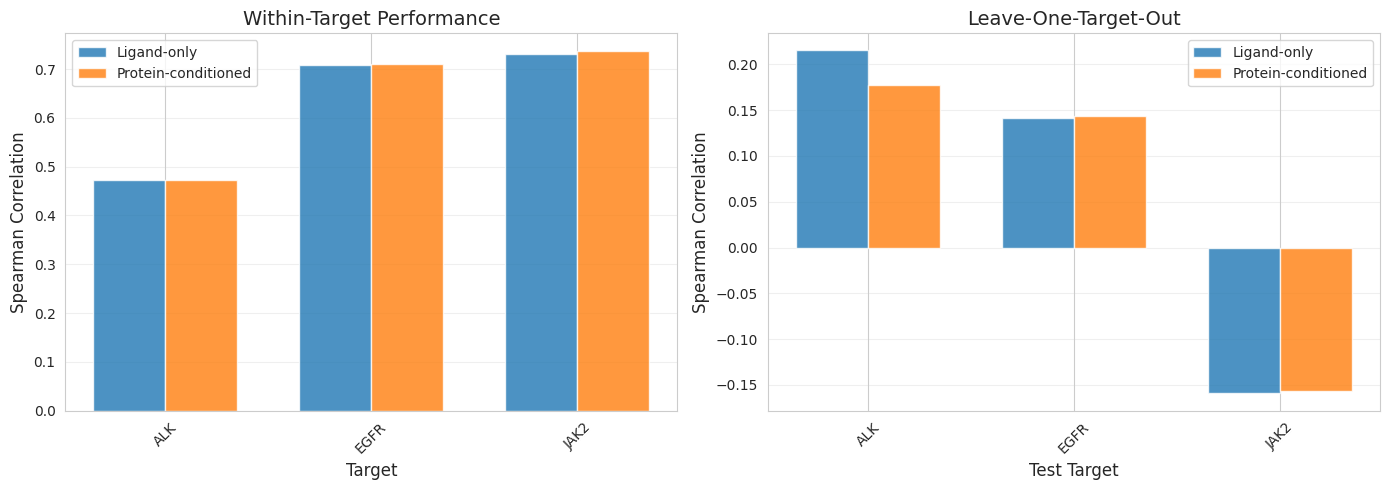

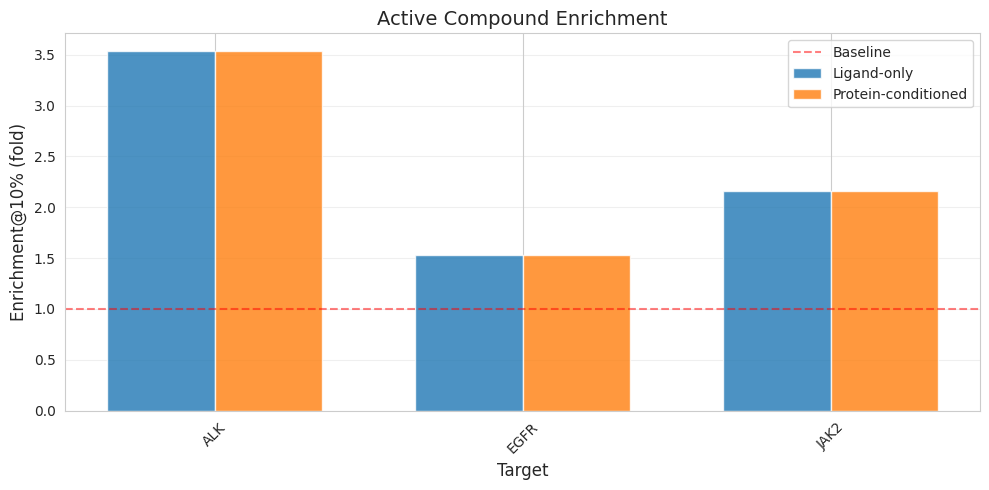


✓ Benchmark plots saved


In [ ]:
# Within-target comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Spearman
ax = axes[0]
pivot = df_within.pivot(index='target', columns='features', values='spearman')
x = np.arange(len(pivot))
width = 0.35
ax.bar(x - width/2, pivot['ligand_only'], width, label='Ligand-only', alpha=0.8)
ax.bar(x + width/2, pivot['protein_conditioned'], width, label='Protein-conditioned', alpha=0.8)
ax.set_xlabel('Target', fontsize=12)
ax.set_ylabel('Spearman Correlation', fontsize=12)
ax.set_title('Within-Target Performance', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(pivot.index, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# LOTO
ax = axes[1]
pivot_loto = df_loto.pivot(index='test_target', columns='features', values='spearman')
x = np.arange(len(pivot_loto))
ax.bar(x - width/2, pivot_loto['ligand_only'], width, label='Ligand-only', alpha=0.8)
ax.bar(x + width/2, pivot_loto['protein_conditioned'], width, label='Protein-conditioned', alpha=0.8)
ax.set_xlabel('Test Target', fontsize=12)
ax.set_ylabel('Spearman Correlation', fontsize=12)
ax.set_title('Leave-One-Target-Out', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(pivot_loto.index, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plots/benchmark_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Enrichment
fig, ax = plt.subplots(figsize=(10, 5))
pivot_enrich = df_enrichment.pivot(index='target', columns='features', values='enrichment@10%')
x = np.arange(len(pivot_enrich))
ax.bar(x - width/2, pivot_enrich['ligand_only'], width, label='Ligand-only', alpha=0.8)
ax.bar(x + width/2, pivot_enrich['protein_conditioned'], width, label='Protein-conditioned', alpha=0.8)
ax.axhline(1.0, color='red', linestyle='--', label='Baseline', alpha=0.5)
ax.set_xlabel('Target', fontsize=12)
ax.set_ylabel('Enrichment@10% (fold)', fontsize=12)
ax.set_title('Active Compound Enrichment', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(pivot_enrich.index, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plots/enrichment_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Benchmark plots saved")

## 11. Train Final Models for Prioritization

In [ ]:
print(f"\n{'='*60}")
print(f"TRAINING FINAL MODELS FOR {PRIMARY_TARGET}")
print(f"{'='*60}")

# Get primary target data
primary_mask = df_features['target_name'] == PRIMARY_TARGET
primary_idx = np.where(primary_mask)[0]

if len(primary_idx) == 0:
    raise ValueError(f"No data for PRIMARY_TARGET: {PRIMARY_TARGET}")

print(f"\nTraining on {len(primary_idx)} {PRIMARY_TARGET} compounds...")

# Train models
if MODEL_TYPE == "rf_ensemble":
    final_models_lig = train_rf_ensemble(X_ligand[primary_idx], y[primary_idx], N_ENSEMBLE, RANDOM_SEED)
    final_models_prot = train_rf_ensemble(X_protein[primary_idx], y[primary_idx], N_ENSEMBLE, RANDOM_SEED)
else:
    final_models_lig = train_xgb_ensemble(X_ligand[primary_idx], y[primary_idx], N_ENSEMBLE, RANDOM_SEED)
    final_models_prot = train_xgb_ensemble(X_protein[primary_idx], y[primary_idx], N_ENSEMBLE, RANDOM_SEED)

print("✓ Final models trained")

# Train off-target models if needed
offtarget_models = {}

if OFF_TARGETS:
    print(f"\nTraining off-target models: {OFF_TARGETS}")

    for off_target in OFF_TARGETS:
        off_mask = df_features['target_name'] == off_target
        off_idx = np.where(off_mask)[0]

        if len(off_idx) > 0:
            print(f"  {off_target}: {len(off_idx)} compounds")

            if MODEL_TYPE == "rf_ensemble":
                off_models = train_rf_ensemble(X_protein[off_idx], y[off_idx], N_ENSEMBLE, RANDOM_SEED)
            else:
                off_models = train_xgb_ensemble(X_protein[off_idx], y[off_idx], N_ENSEMBLE, RANDOM_SEED)

            offtarget_models[off_target] = off_models

print("\n✓ All models ready for prioritization")


TRAINING FINAL MODELS FOR EGFR

Training on 807 EGFR compounds...
✓ Final models trained

Training off-target models: ['ALK', 'JAK2']
  ALK: 689 compounds
  JAK2: 937 compounds

✓ All models ready for prioritization


## 12. Makeability Scoring (Reuse from v2)

In [ ]:
def compute_sa_score_improved(mol):
    complexity = 0.0
    ri = mol.GetRingInfo()
    n_rings = len(ri.AtomRings())
    complexity += n_rings * 0.5

    for ring in ri.AtomRings():
        if len(ring) > 8:
            complexity += 2.0

    n_spiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
    n_bridge = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
    complexity += n_spiro * 1.0 + n_bridge * 0.5

    n_stereo = len(Chem.FindMolChiralCenters(mol, includeUnassigned=True))
    complexity += n_stereo * 0.5

    n_atoms = mol.GetNumHeavyAtoms()
    if n_atoms > 50:
        complexity += (n_atoms - 50) * 0.1

    return 1.0 + min(9.0, complexity)

def compute_makeability_score(mol):
    sa_score = compute_sa_score_improved(mol)
    sa_component = (10 - sa_score) / 9.0

    mw = Descriptors.MolWt(mol)
    mw_penalty = max(0, 1.0 - (mw - MW_THRESHOLD) / 300) if mw > MW_THRESHOLD else 1.0

    n_rot = Lipinski.NumRotatableBonds(mol)
    rot_penalty = max(0, 1.0 - (n_rot - ROTATABLE_BONDS_THRESHOLD) * 0.1) if n_rot > ROTATABLE_BONDS_THRESHOLD else 1.0

    n_rings = rdMolDescriptors.CalcNumRings(mol)
    ring_penalty = max(0, 1.0 - (n_rings - RING_COUNT_THRESHOLD) * 0.2) if n_rings > RING_COUNT_THRESHOLD else 1.0

    return 0.5 * sa_component + 0.2 * mw_penalty + 0.15 * rot_penalty + 0.15 * ring_penalty

print("✓ Makeability functions defined")

✓ Makeability functions defined


## 13. Compound Prioritization with Selectivity

In [ ]:
def prioritize_with_selectivity(smiles_list, primary_models, offtarget_models, target_embed, offtarget_embeds):
    """
    Prioritize compounds with selectivity scoring.
    """
    results = []

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue

        try:
            # Ligand features
            fp = compute_morgan_fingerprint(mol)
            desc = compute_descriptors(mol)
            lig_feat = np.concatenate([fp, desc])

            # Primary target prediction
            prot_feat_primary = np.concatenate([lig_feat, target_embed]).reshape(1, -1)
            pred_primary, std_primary = predict_with_uncertainty(primary_models, prot_feat_primary)
            pred_primary = pred_primary[0]
            std_primary = std_primary[0]

            # Off-target predictions
            pred_offmax = 0.0
            if offtarget_models:
                off_preds = []
                for off_name, off_models in offtarget_models.items():
                    off_embed = offtarget_embeds[off_name]
                    prot_feat_off = np.concatenate([lig_feat, off_embed]).reshape(1, -1)
                    pred_off, _ = predict_with_uncertainty(off_models, prot_feat_off)
                    off_preds.append(pred_off[0])
                pred_offmax = max(off_preds) if off_preds else 0.0

            selectivity = pred_primary - pred_offmax

            # Conservative score
            pred_conservative = pred_primary - LAMBDA_UNCERTAINTY * std_primary

            # Makeability
            makeability = compute_makeability_score(mol)

            # Combined score
            norm_potency = (pred_primary - 3.0) / 8.0
            norm_selectivity = (selectivity + 2.0) / 4.0  # Assume range [-2, 2]
            norm_uncertainty = 1.0 - (std_primary / 2.0)  # Lower uncertainty = better

            combined_score = (
                WEIGHT_POTENCY * norm_potency +
                WEIGHT_SELECTIVITY * norm_selectivity +
                WEIGHT_MAKEABILITY * makeability +
                WEIGHT_UNCERTAINTY * norm_uncertainty
            )

            results.append({
                'smiles': smiles,
                'pred_pActivity': pred_primary,
                'pred_uncertainty': std_primary,
                'pred_conservative': pred_conservative,
                'pred_offmax': pred_offmax,
                'selectivity': selectivity,
                'makeability': makeability,
                'combined_score': combined_score
            })
        except:
            continue

    df = pd.DataFrame(results)
    df = df.sort_values('combined_score', ascending=False).reset_index(drop=True)

    return df


# Prioritize primary target test set
print(f"\n{'='*60}")
print(f"PRIORITIZATION: {PRIMARY_TARGET}")
print(f"{'='*60}")

# Get test compounds for primary target
if PRIMARY_TARGET in scaffold_splits:
    _, _, test_idx = scaffold_splits[PRIMARY_TARGET]
    test_smiles = df_features.iloc[test_idx]['smiles'].tolist()
else:
    # Use all primary target compounds
    test_smiles = df_features[df_features['target_name'] == PRIMARY_TARGET]['smiles'].tolist()

print(f"\nPrioritizing {len(test_smiles)} compounds...")

# Get embeddings
primary_embed = target_embed_map[PRIMARY_TARGET]
offtarget_embeds = {name: target_embed_map[name] for name in OFF_TARGETS if name in target_embed_map}

df_prioritized = prioritize_with_selectivity(
    test_smiles,
    final_models_prot,
    offtarget_models,
    primary_embed,
    offtarget_embeds
)

print(f"\n✓ Prioritized {len(df_prioritized)} compounds")
print("\nTop 10:")
print(df_prioritized[['smiles', 'pred_pActivity', 'selectivity', 'makeability', 'combined_score']].head(10))

# Save
df_prioritized.to_csv(f'{OUTPUT_DIR}/prioritized_compounds.csv', index=False)
df_prioritized.head(20).to_csv(f'{OUTPUT_DIR}/top_20_compounds.csv', index=False)

print(f"\n✓ Saved prioritization results")


PRIORITIZATION: EGFR

Prioritizing 127 compounds...


[16:15:59] DEPRECATION WARNING: please use MorganGenerator
[16:16:00] DEPRECATION WARNING: please use MorganGenerator
[16:16:00] DEPRECATION WARNING: please use MorganGenerator
[16:16:01] DEPRECATION WARNING: please use MorganGenerator
[16:16:01] DEPRECATION WARNING: please use MorganGenerator
[16:16:02] DEPRECATION WARNING: please use MorganGenerator
[16:16:03] DEPRECATION WARNING: please use MorganGenerator
[16:16:03] DEPRECATION WARNING: please use MorganGenerator
[16:16:04] DEPRECATION WARNING: please use MorganGenerator
[16:16:04] DEPRECATION WARNING: please use MorganGenerator
[16:16:05] DEPRECATION WARNING: please use MorganGenerator
[16:16:05] DEPRECATION WARNING: please use MorganGenerator
[16:16:06] DEPRECATION WARNING: please use MorganGenerator
[16:16:06] DEPRECATION WARNING: please use MorganGenerator
[16:16:07] DEPRECATION WARNING: please use MorganGenerator
[16:16:08] DEPRECATION WARNING: please use MorganGenerator
[16:16:08] DEPRECATION WARNING: please use MorganGenerat


✓ Prioritized 127 compounds

Top 10:
                                              smiles  pred_pActivity  \
0                    Nc1cc2ncnc(Nc3cccc(Br)c3)c2cc1N        9.231611   
1                     Nc1ccc2c(Nc3cccc(Br)c3)ncnc2c1        9.089246   
2                    Oc1cc2ncnc(Nc3cccc(Br)c3)c2cc1O        9.148602   
3           Brc1cccc(Nc2ncnc3cnc(NCCc4ccccn4)cc23)c1        8.939921   
4  [O-][N+]1(CCCNc2cc3ncnc(Nc4cccc(Br)c4)c3cn2)CC...        8.793529   
5             C=CC(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1        8.585433   
6                    CNc1ccc2c(Nc3cccc(Br)c3)ncnc2c1        8.374699   
7  C=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCOC...        8.414094   
8          C=CC(=O)Nc1ccc2ncnc(Nc3ccc(F)c(Cl)c3)c2c1        8.615595   
9                Brc1cccc(Nc2ncnc3cc4[nH]ncc4cc23)c1        8.434192   

   selectivity  makeability  combined_score  
0     3.093040     0.916667        0.921603  
1     2.900851     0.916667        0.906263  
2     2.683315     0.916667    

## 14. Generate PDF Report

In [ ]:
def create_comprehensive_report(output_path=f'{OUTPUT_DIR}/report.pdf'):
    print("\nGenerating PDF report...")

    with PdfPages(output_path) as pdf:
        # Title page
        fig = plt.figure(figsize=(11, 8.5))
        fig.text(0.5, 0.7, 'Protein-Conditioned QSAR Report', ha='center', fontsize=22, weight='bold')
        fig.text(0.5, 0.6, f'Targets: {", ".join([t["name"] for t in TARGETS])}', ha='center', fontsize=14)
        fig.text(0.5, 0.5, f'Primary: {PRIMARY_TARGET}', ha='center', fontsize=14)
        fig.text(0.5, 0.4, f'Model: {MODEL_TYPE} (N={N_ENSEMBLE})', ha='center', fontsize=12)
        fig.text(0.5, 0.3, f'Date: {datetime.now().strftime("%Y-%m-%d %H:%M")}', ha='center', fontsize=10)
        plt.axis('off')
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()

        # Benchmark summary
        fig = plt.figure(figsize=(11, 8.5))
        fig.text(0.5, 0.95, 'Benchmark Summary', ha='center', fontsize=18, weight='bold')

        summary_text = f"""
Within-Target Scaffold Split (Spearman):
{df_within.groupby('features')['spearman'].mean().to_string()}

Leave-One-Target-Out (Spearman):
{df_loto.groupby('features')['spearman'].mean().to_string()}

Enrichment@10% (mean):
{df_enrichment.groupby('features')['enrichment@10%'].mean().to_string()}
        """

        fig.text(0.1, 0.8, summary_text, fontsize=10, verticalalignment='top', family='monospace')
        plt.axis('off')
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()

        # Add plots
        plot_files = [
            f'{OUTPUT_DIR}/plots/benchmark_comparison.png',
            f'{OUTPUT_DIR}/plots/enrichment_comparison.png'
        ]

        for plot_file in plot_files:
            if os.path.exists(plot_file):
                img = plt.imread(plot_file)
                fig = plt.figure(figsize=(11, 8.5))
                plt.imshow(img)
                plt.axis('off')
                pdf.savefig(fig, bbox_inches='tight')
                plt.close()

        # Top 20 table
        fig = plt.figure(figsize=(11, 8.5))
        fig.text(0.5, 0.95, f'Top 20 Compounds ({PRIMARY_TARGET})', ha='center', fontsize=16, weight='bold')

        top_20_data = df_prioritized.head(20)[[
            'pred_pActivity', 'selectivity', 'makeability', 'combined_score'
        ]].round(3)

        ax = fig.add_subplot(111)
        ax.axis('tight')
        ax.axis('off')

        table = ax.table(
            cellText=top_20_data.values,
            colLabels=top_20_data.columns,
            cellLoc='center',
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1, 2)

        pdf.savefig(fig, bbox_inches='tight')
        plt.close()

    print(f"✓ Report saved to {output_path}")

create_comprehensive_report()


Generating PDF report...
✓ Report saved to ./outputs/report.pdf


## 15. Summary

In [ ]:
print(f"\n{'='*80}")
print("PIPELINE COMPLETE ✓")
print(f"{'='*80}")

print(f"\n📊 Dataset:")
print(f"   Targets: {valid_targets}")
print(f"   Total compounds: {len(df_clean)}")

print(f"\n🧬 Protein Embeddings:")
print(f"   Mode: {embed_type}")
print(f"   Dimension: {list(target_embed_map.values())[0].shape[0] if target_embed_map else 'N/A'}")

print(f"\n🎯 Benchmarks:")
print(f"   Within-target (Spearman):")
for feat in ['ligand_only', 'protein_conditioned']:
    mean_sp = df_within[df_within['features'] == feat]['spearman'].mean()
    print(f"     {feat}: {mean_sp:.3f}")

print(f"   LOTO (Spearman):")
for feat in ['ligand_only', 'protein_conditioned']:
    mean_sp = df_loto[df_loto['features'] == feat]['spearman'].mean()
    print(f"     {feat}: {mean_sp:.3f}")

print(f"   Enrichment@10%:")
for feat in ['ligand_only', 'protein_conditioned']:
    mean_enrich = df_enrichment[df_enrichment['features'] == feat]['enrichment@10%'].mean()
    print(f"     {feat}: {mean_enrich:.2f}x")

print(f"\n🔬 Prioritization ({PRIMARY_TARGET}):")
print(f"   Ranked: {len(df_prioritized)} compounds")
print(f"   Selectivity: {len(offtarget_models)} off-targets")

print(f"\n📁 Output Files:")
print(f"   {OUTPUT_DIR}/cleaned_data.csv")
print(f"   {OUTPUT_DIR}/benchmarks/ (within_target, LOTO, enrichment)")
print(f"   {OUTPUT_DIR}/prioritized_compounds.csv")
print(f"   {OUTPUT_DIR}/top_20_compounds.csv")
print(f"   {OUTPUT_DIR}/report.pdf")
print(f"   {OUTPUT_DIR}/plots/")

print(f"\n{'='*80}")
print("🏆 TOP CANDIDATE:")
top = df_prioritized.iloc[0]
print(f"   SMILES: {top['smiles']}")
print(f"   Predicted pActivity: {top['pred_pActivity']:.2f} ± {top['pred_uncertainty']:.2f}")
print(f"   Selectivity: {top['selectivity']:.2f}")
print(f"   Makeability: {top['makeability']:.2f}")
print(f"   Combined score: {top['combined_score']:.3f}")

print(f"\n✅ Done!")


PIPELINE COMPLETE ✓

📊 Dataset:
   Targets: ['ALK', 'EGFR', 'JAK2']
   Total compounds: 2433

🧬 Protein Embeddings:
   Mode: esm2
   Dimension: 320

🎯 Benchmarks:
   Within-target (Spearman):
     ligand_only: 0.637
     protein_conditioned: 0.640
   LOTO (Spearman):
     ligand_only: 0.066
     protein_conditioned: 0.055
   Enrichment@10%:
     ligand_only: 2.41x
     protein_conditioned: 2.41x

🔬 Prioritization (EGFR):
   Ranked: 127 compounds
   Selectivity: 2 off-targets

📁 Output Files:
   ./outputs/cleaned_data.csv
   ./outputs/benchmarks/ (within_target, LOTO, enrichment)
   ./outputs/prioritized_compounds.csv
   ./outputs/top_20_compounds.csv
   ./outputs/report.pdf
   ./outputs/plots/

🏆 TOP CANDIDATE:
   SMILES: Nc1cc2ncnc(Nc3cccc(Br)c3)c2cc1N
   Predicted pActivity: 9.23 ± 0.12
   Selectivity: 3.09
   Makeability: 0.92
   Combined score: 0.922

✅ Done!
